<center> <h1>Αναγνώριση Προτύπων - Προπαρασκευή 3ης Εργαστηριακής Άσκησης</h1> </center>

---

<center> <h2>Θέμα: Αναγνώριση Είδους και Εξαγωγή Συναισθήματος από Μουσική</h2> </center>
<center> <h2>ΣΧΟΛΗ: ΣΗΜΜΥ</h2> </center>

Ονοματεπώνυμο | Αριθμός Μητρώου
------------ | -------------
Γιάννης Πιτόσκας | 03115077
Αντώνης Παπαοικονόμου | 03115140

# Βήμα 0

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# data_path = "../input/patreco3-multitask-affective-music/data/"
data_path = os.path.abspath("Q:\Files\patreco3-multitask-affective-music\data")

print(os.listdir(data_path))

['fma_genre_spectrograms', 'fma_genre_spectrograms_beat', 'multitask_dataset', 'multitask_dataset_beat']


# Βήμα 1

Με βάση τον κώδικα που έχουμε από το [Data Loading Tutorial](https://www.kaggle.com/geoparslp/data-loading-tutorial/data):

In [2]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}

# TODO: Comment on howv the train and validation splits are created.
# TODO: It's useful to set the seed when debugging but when experimenting ALWAYS set seed=None. Why?
def torch_train_val_split(
        dataset, batch_train, batch_eval,
        val_size=.2, shuffle=True, seed=None):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    return train_loader, val_loader


def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T


def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


# TODO: Comment on why padding is needed
class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

        
class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_fused_spectrogram):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, self.gold_labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(self.gold_labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(self.gold_labels)).astype('int64')

    def get_files_labels(self, txt, class_mapping):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], self.gold_labels[item], l

    def __len__(self):
        return len(self.labels)

**(β)** Διαβάζοντας τα αρχεία από το path `/fma_genre_spectrograms/` έχουμε:

In [3]:
fma_genre_spectr_path = os.path.join(data_path, "fma_genre_spectrograms")

# print(os.listdir(fma_genre_spectr_path))
    
train_specs_mel = SpectrogramDataset(
     fma_genre_spectr_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)

print("Train Loaded Successfuly.", "Train data length:", len(train_specs_mel))

test_specs_mel = SpectrogramDataset(
     fma_genre_spectr_path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)
    
print("Test Loaded Successfuly.", "Test data length:", len(test_specs_mel))

Train Loaded Successfuly. Train data length: 2305
Test Loaded Successfuly. Test data length: 575


**(α)** Παρακάτω επιλέγουμε δυο τυχαία δείγματα με διαφορετικά labels τα οποία και θα χρησιμοποιήσουμε και για τα επόμενα ερωτήματα για να έχουμε consistancy και να μπορούμε να τα συγκρίνουμε μεταξύ τους.

In [4]:
import random

sr = 22050

rand_index_1 = random.randint(0, len(train_specs_mel)-1)
rand_index_2 = random.randint(0, len(train_specs_mel)-1)
rand_sample_1 = train_specs_mel[rand_index_1]
rand_sample_2 = train_specs_mel[rand_index_2]
while rand_sample_2[1] == rand_sample_1[1]:
    rand_index_2 = random.randint(0, len(train_specs_mel)-1)
    rand_sample_2 = train_specs_mel[rand_index_2]

l1 = rand_sample_1[3]
l2 = rand_sample_2[3]

# print(specs_fused.label_transformer.inverse_transform([rand_sample_1[1]]))
# print(rand_sample_1[2])
# print(rand_sample_2[2])
# print(rand_sample_1[0].shape)
# print(rand_sample_2[0].shape)
# print(rand_sample_1[3])
# print(rand_sample_2[3])

**(γ)**

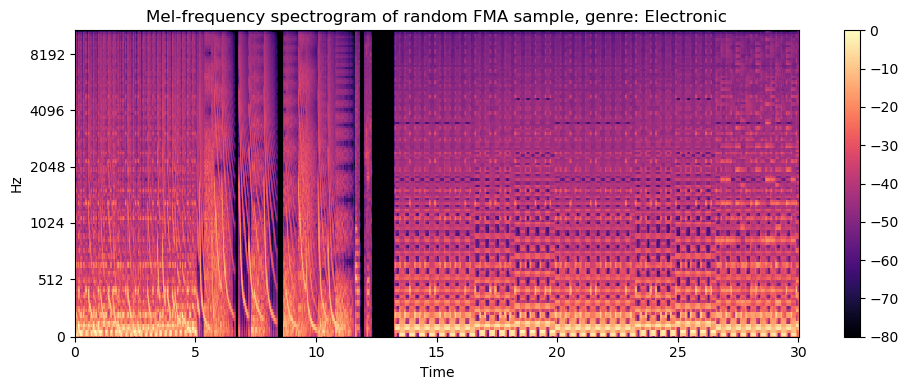

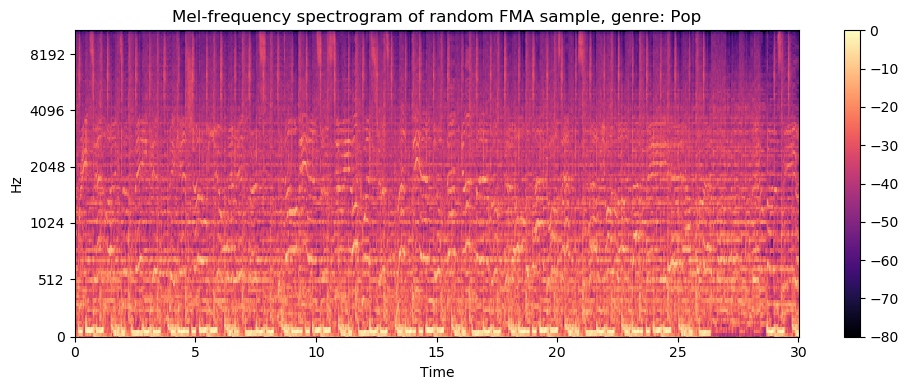

In [5]:
%matplotlib inline
import IPython.display
import librosa.display
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_1[0], ref=np.max)
librosa.display.specshow(rand_sample_1[0][:l1][:].T, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel-frequency spectrogram of random FMA sample, genre: '+rand_sample_1[2])
plt.tight_layout()
plt.show()

# rand_sample_1_audio = librosa.feature.inverse.mel_to_audio(rand_sample_1[0])
# IPython.display.Audio(rand_sample_1_audio, rate=sr)

plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_2[0], ref=np.max)
librosa.display.specshow(rand_sample_2[0][:l2][:].T, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel-frequency spectrogram of random FMA sample, genre: '+rand_sample_2[2])
plt.tight_layout()
plt.show()

# rand_sample_2_audio = librosa.feature.inverse.mel_to_audio(rand_sample_2[0])
# IPython.display.Audio(rand_sample_2_audio, rate=sr)

>Παρατηρούμε

# Βήμα 2

**(α)**

In [6]:
print(rand_sample_1[0].shape)
print(rand_sample_2[0].shape)

(1293, 128)
(1293, 128)


**(β)** Διαβάζοντας τα αρχεία από το path `/fma_genre_spectrograms_beat/` έχουμε:

In [7]:
fma_genre_spectr_beat_path = os.path.join(data_path, "fma_genre_spectrograms_beat")
    
train_specs_beat_mel = SpectrogramDataset(
     fma_genre_spectr_beat_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)

print("Train Loaded Successfuly.", "Train data length:", len(train_specs_beat_mel))

test_specs_beat_mel = SpectrogramDataset(
     fma_genre_spectr_beat_path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)
    
print("Test Loaded Successfuly.", "Test data length:", len(test_specs_beat_mel))

Train Loaded Successfuly. Train data length: 2305
Test Loaded Successfuly. Test data length: 575


In [8]:
rand_sample_1 = train_specs_beat_mel[rand_index_1]
rand_sample_2 = train_specs_beat_mel[rand_index_2]

l1 = rand_sample_1[3]
l2 = rand_sample_2[3]

print(rand_sample_1[0].shape)
print(rand_sample_2[0].shape)

(129, 128)
(129, 128)


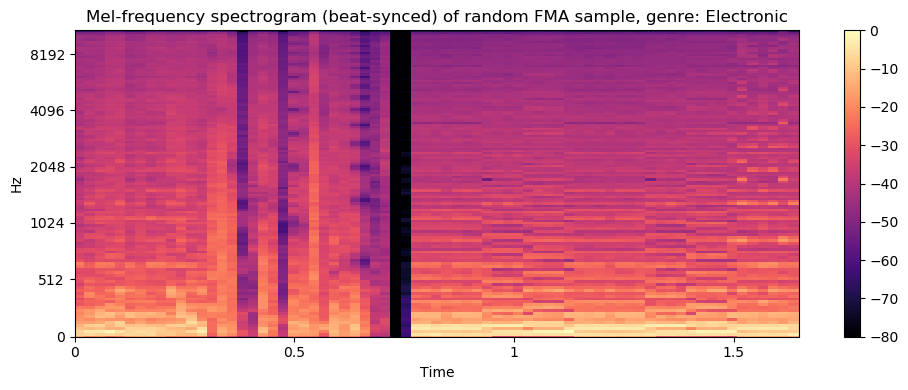

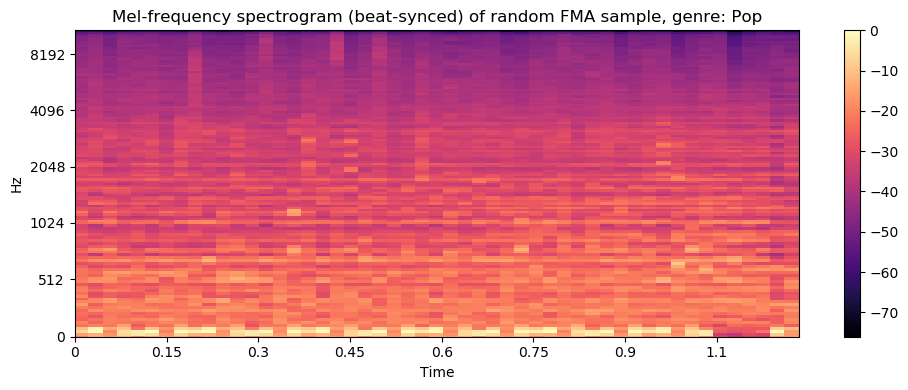

In [9]:
import IPython.display
import librosa.display
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

sr = 22050

plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_1[0], ref=np.max)
librosa.display.specshow(rand_sample_1[0][:l1][:].T, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel-frequency spectrogram (beat-synced) of random FMA sample, genre: '+rand_sample_1[2])
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_2[0], ref=np.max)
librosa.display.specshow(rand_sample_2[0][:l2][:].T, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel-frequency spectrogram (beat-synced) of random FMA sample, genre: '+rand_sample_2[2])
plt.tight_layout()
plt.show()

# Βήμα 3

Για τα χρωμογραφήματα έχουμε:

Για την πλήρη πληροφορία:

In [10]:
chromas_train = SpectrogramDataset(
     fma_genre_spectr_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_chromagram)

print("Train Loaded Successfuly.", "Train data length:", len(chromas_train))

chromas_test = SpectrogramDataset(
     fma_genre_spectr_path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_chromagram)

print("Test Loaded Successfuly.", "Test data length:", len(chromas_test))

Train Loaded Successfuly. Train data length: 2305
Test Loaded Successfuly. Test data length: 575


In [11]:
rand_sample_1 = chromas_train[rand_index_1]
rand_sample_2 = chromas_train[rand_index_2]

l1 = rand_sample_1[3]
l2 = rand_sample_2[3]

print(rand_sample_1[0].shape)
print(rand_sample_2[0].shape)

(1293, 12)
(1293, 12)


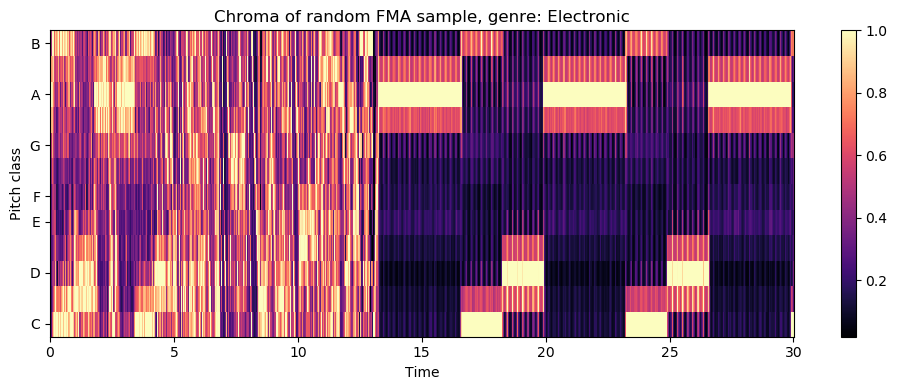

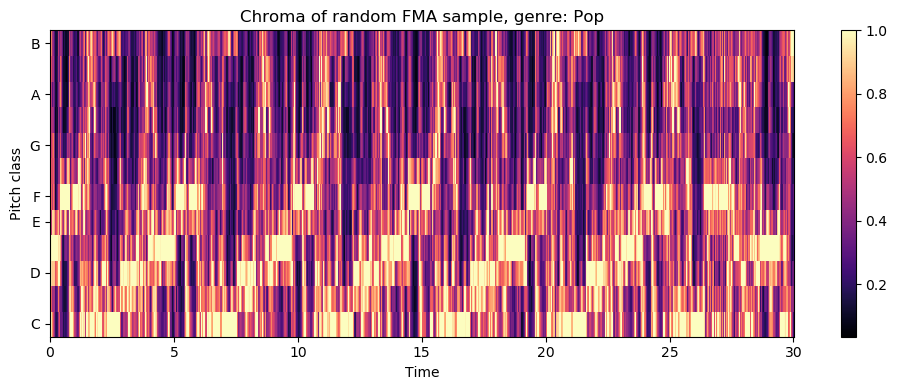

In [12]:
import IPython.display
import librosa.display
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

sr = 22050

plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_1[0], ref=np.max)
librosa.display.specshow(rand_sample_1[0][:l1][:].T, sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma of random FMA sample, genre: '+rand_sample_1[2])
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_2[0], ref=np.max)
librosa.display.specshow(rand_sample_2[0][:l2][:].T, sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma of random FMA sample, genre: '+rand_sample_2[2])
plt.tight_layout()
plt.show()

Για τα beat-synced δεδομένα:

In [13]:
chromas_beat_train = SpectrogramDataset(
     fma_genre_spectr_beat_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_chromagram)

print("Train Loaded Successfuly.", "Train data length:", len(chromas_beat_train))

chromas_beat_test = SpectrogramDataset(
     fma_genre_spectr_beat_path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_chromagram)

print("Test Loaded Successfuly.", "Test data length:", len(chromas_beat_test))

Train Loaded Successfuly. Train data length: 2305
Test Loaded Successfuly. Test data length: 575


In [14]:
rand_sample_1 = chromas_beat_train[rand_index_1]
rand_sample_2 = chromas_beat_train[rand_index_2]

l1 = rand_sample_1[3]
l2 = rand_sample_2[3]

print(rand_sample_1[0].shape)
print(rand_sample_2[0].shape)

(129, 12)
(129, 12)


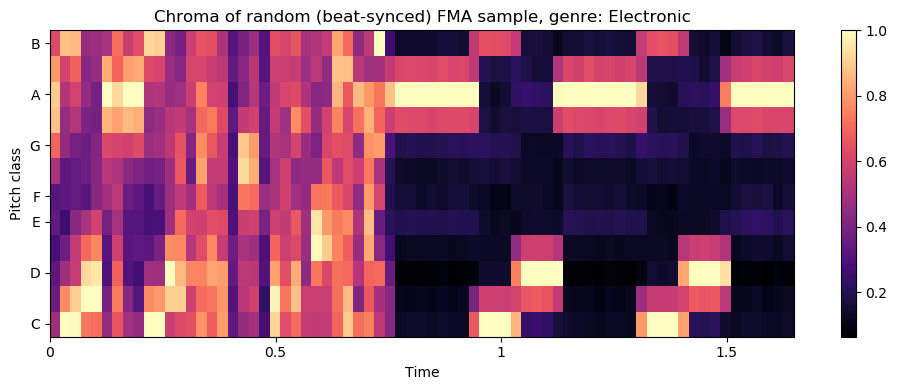

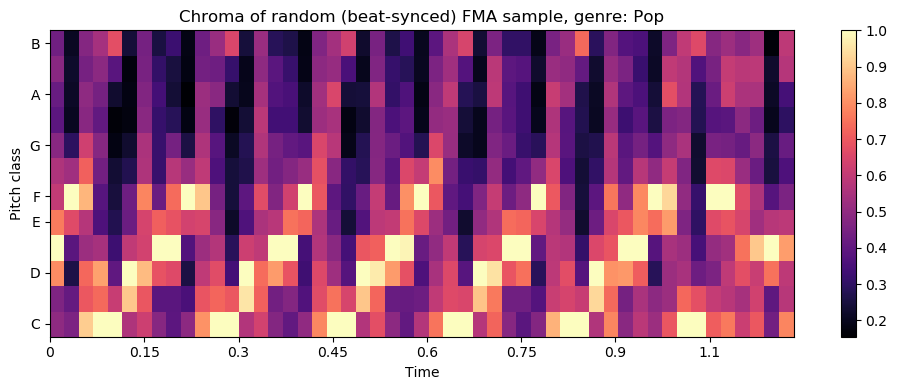

In [15]:
import IPython.display
import librosa.display
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

sr = 22050

plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_1[0], ref=np.max)
librosa.display.specshow(rand_sample_1[0][:l1][:].T, sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma of random (beat-synced) FMA sample, genre: '+rand_sample_1[2])
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_2[0], ref=np.max)
librosa.display.specshow(rand_sample_2[0][:l2][:].T, sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma of random (beat-synced) FMA sample, genre: '+rand_sample_2[2])
plt.tight_layout()
plt.show()

# Βήμα 4

**(α)** Στη συνέχεια γίνεται χρήση μιας έτοιμης υλοποίησης `PyTorch Dataset` η οποία διαβάζει τα δεδομένα και επιστρέφει τα δείγματα:

In [16]:
specs_without_mapping = SpectrogramDataset(
     fma_genre_spectr_path,
     train=True,
     class_mapping={},
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)

print("Train Loaded Successfuly.", "Train data length:", len(specs_without_mapping))

Train Loaded Successfuly. Train data length: 3069


**(β)** Έπειτα, ξαναδιαβάζουμε τα δεδομένα με την ίδια υλοποίηση `PyTorch Dataset` με προηγουμένως, αλλά αυτή τη φορά μεταβάλλοντας την παράμετρο class_mapping. Στην ουσία με αυτήν την παράμετρο κάνουμε **_map_** μερικές κλάσεις σε κάποιες ήδη υπάρχουσες που μπορούν να θεωρηθούν ευρύτερες με σκοπό την συγχώνευση όμοιων μεταξύ τους κλάσεων, ή αφαιρούμε εντελώς αυτές που παρατηρούμε ότι αντιπροσωπεύονται από πολύ μικρό αριθμό δειγμάτων:

In [17]:
specs_with_mapping = SpectrogramDataset(
     fma_genre_spectr_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)

print("Train Loaded Successfuly.", "Train data length:", len(specs_with_mapping))

Train Loaded Successfuly. Train data length: 2305


**(γ)** Παρακάτω φαίνονται τα ιστογράμματα που αφορούν τον αριθμό δειγμάτων που αντιστοιχούν στην εκάστοτε κλάση **χωρίς** και **με** συγχώνευση κλάσεων:

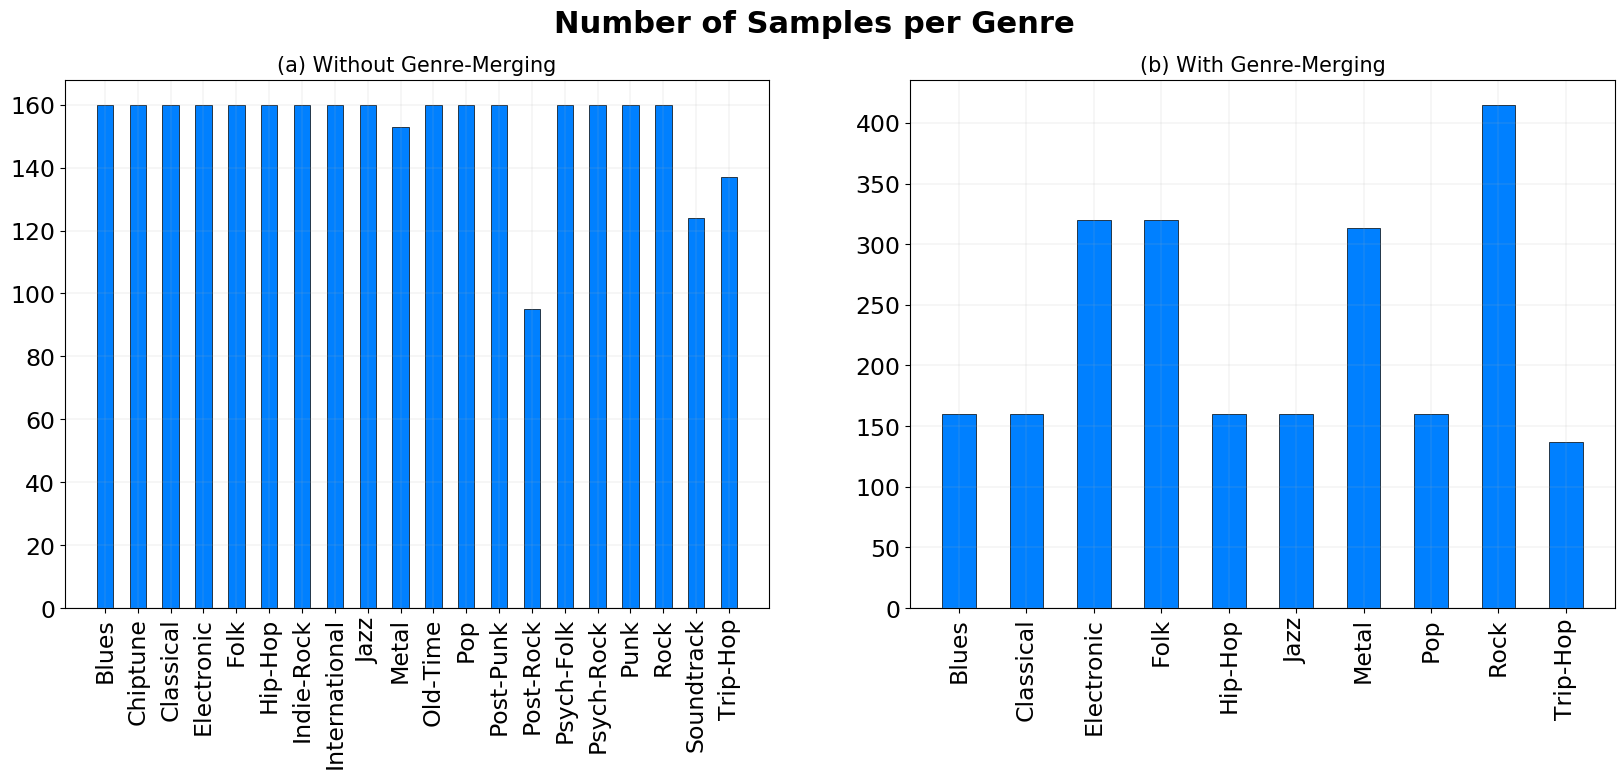

In [18]:
# Initialize subplots
fig, axs = plt.subplots(1,2,figsize=(20,7))
fig.suptitle("Number of Samples per Genre", size=22, fontweight='demibold' )

# Before Class Merging
unique, counts = np.unique(specs_without_mapping.gold_labels, return_counts=True)
axs[0].set_title("(a) Without Genre-Merging", size=15)
axs[0].bar(unique, counts, width=0.5, color='#0080FF', alpha=1.0, edgecolor='k', linewidth=0.5)
[tick.set_rotation(90) for tick in axs[0].get_xticklabels()]
axs[0].tick_params(labelsize=17)
axs[0].grid(linewidth=0.3, alpha=0.5)

# After Class Merging
unique, counts = np.unique(specs_with_mapping.gold_labels, return_counts=True)
axs[1].set_title("(b) With Genre-Merging", size=15)
axs[1].bar(unique, counts, width=0.5, color='#0080FF', alpha=1.0, edgecolor='k', linewidth=0.5)
[tick.set_rotation(90) for tick in axs[1].get_xticklabels()]
axs[1].tick_params(labelsize=17)
axs[1].grid(linewidth=0.3, alpha=0.5)

plt.show()


# for i in range(len(errors)):
#     ys = [x[1] for x in sorted(errors[i],key = lambda x: x[0])]
#     y_pos = np.arange(len(xs))
#     axs[i // 4, i % 4].bar(y_pos, ys, align='center', alpha=0.5)
#     axs[i // 4, i % 4].tick_params(labelsize=8, length=0)
#     axs[i // 4, i % 4].set_title(names[i], fontsize=8) 

# plt.setp(axs, xticks=xs, xticklabels=xs, yticks=np.arange(0,101,10))

# plt.figure(figsize=(15,5))
# plt.title("Number of Samples per Genre (without genre merging)")
# unique, counts = np.unique(specs_without_mapping.gold_labels, return_counts=True)
# plt.xticks(rotation=45)
# plt.bar(unique, counts, width=0.5, color='#0080FF', alpha=1.0, edgecolor='k', linewidth=0.5)
# plt.grid(linewidth=0.3, alpha=0.5)
# plt.show()

# plt.figure(figsize=(10,5))
# plt.title("Number of Samples per Genre (with genre merging)")
# unique, counts = np.unique(specs_with_mapping.gold_labels, return_counts=True)
# plt.xticks(rotation=45)
# plt.bar(unique, counts, width=0.5, color='#0080FF', alpha=1.0, edgecolor='k', linewidth=0.5)
# plt.grid(linewidth=0.3, alpha=0.5)
# plt.show()


# Βήμα 5

Παρακάτω έχουμε μια υλοποίηση για ένα `LSTM` δίκτυο:

In [19]:
import torch
from torch import nn

class BasicLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.0, 
                 num_layers=1, bidirectional=False, isPackedSequence=False):
        super(BasicLSTM, self).__init__()
        
        self.dropout_prob = dropout_prob
        self.bidirectional = bidirectional
        self.feature_size = hidden_dim * 2 if self.bidirectional else hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.isPackedSequence = isPackedSequence
        
        # Initialize the LSTM, Dropout, Output layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                                dropout=dropout_prob, batch_first=True, bidirectional= bidirectional)
        
        self.drop = nn.Dropout(p=dropout_prob)
        
        self.fc = nn.Linear(self.feature_size, self.output_dim)
        

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        N, L, D = x.size()
        
        if self.isPackedSequence:
            x = pack_padded_sequence(x, lengths, batch_first=True)
        
        out, _ = self.lstm(x)
        
        if self.isPackedSequence:
            out, _ = pad_packed_sequence(out, batch_first=True)
        
        dropped = self.drop(out)
        
        last = self.last_timestep(dropped, lengths)
        
        last_outputs = self.fc(last)
        
        # You must have all of the outputs of the LSTM
        # but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
              
        return last_outputs
    
    

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)
        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

In [20]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}\n\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...\n\n')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [21]:
import math
import sys

def progress(loss, epoch, batch, batch_size, dataset_size):
    """
    Print the progress of the training for each epoch
    """
    batches = math.ceil(float(dataset_size) / batch_size)
    count = batch * batch_size
    bar_len = 40
    filled_len = int(round(bar_len * count / float(dataset_size)))

    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    status = 'Epoch {}, Loss: {:.4f}'.format(epoch, loss)
    _progress_str = "\r \r [{}] ...{}".format(bar, status)
    sys.stdout.write(_progress_str)
    sys.stdout.flush()

    if batch == batches:
        print()

In [22]:
import torch
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

def train_dataset(_epoch, dataloader, model, loss_function, optimizer):
    
    model.train()
    running_loss = 0.0

    # obtain the model's device ID
    device = next(model.parameters()).device

    for index, batch in enumerate(dataloader, 1):

        # get the inputs (batch)
        inputs, labels, _, lengths = batch
        
#         inputs = inputs.double()
        
        # Step 1 - move the batch tensors to the right device and also sort by length for packed sequence
        
        if model.isPackedSequence:
            sorted_by_len = sorted(zip(lengths, labels, inputs), key=lambda pair: pair[0], reverse=True) 
            lengths = Variable(torch.tensor([x for x, _, _ in sorted_by_len])).to(device)
            labels = Variable(torch.tensor([x for _, x, _ in sorted_by_len])).to(device)
            inputs = Variable(torch.cat([x.view(1, x.size(0), -1) for _, _, x in sorted_by_len])).to(device)
        else:            
            inputs = Variable(inputs).to(device).float()
            labels = Variable(labels).to(device)
            lengths = Variable(lengths).to(device)

        optimizer.zero_grad()

        # Step 2 - forward pass: y' = model(x)
        outputs = model(inputs, lengths)

        # Step 3 - compute loss: L = loss_function(y, y')
        loss = loss_function(outputs, labels)

        # Step 4 - backward pass: compute gradient wrt model parameters
        loss.backward()

        # Step 5 - update weights
        optimizer.step()

        running_loss += loss.data.item()

        # print statistics
        progress(loss=loss.data.item(),
                 epoch=_epoch,
                 batch=index,
                 batch_size=dataloader.batch_size,
                 dataset_size=len(dataloader.dataset))

    return running_loss / index


def eval_dataset(dataloader, model, loss_function):
    
    # IMPORTANT: switch to eval mode
    # disable regularization layers, such as Dropout
    model.eval()
    running_loss = 0.0

    y_pred = []  # the predicted labels
    y = []  # the gold labels

    # obtain the model's device ID
    device = next(model.parameters()).device

    # IMPORTANT: in evaluation mode, we don't want to keep the gradients
    # so we do everything under torch.no_grad()
    with torch.no_grad():
        for index, batch in enumerate(dataloader, 1):

            # get the inputs (batch)
            inputs, labels, _, lengths = batch
            
#             inputs = inputs.double()

            # Step 1 - move the batch tensors to the right device and also sort by length for packed sequence
            
            if model.isPackedSequence:
                sorted_by_len = sorted(zip(lengths, labels, inputs), key=lambda pair: pair[0], reverse=True) 
                lengths = Variable(torch.tensor([x for x, _, _ in sorted_by_len])).to(device)
                labels = Variable(torch.tensor([x for _, x, _ in sorted_by_len])).to(device)
                inputs = Variable(torch.cat([x.view(1, x.size(0), -1) for _, _, x in sorted_by_len])).to(device)
            else:            
                inputs = Variable(inputs).to(device).float()
                labels = Variable(labels).to(device)
                lengths = Variable(lengths).to(device)
                    
            # Step 2 - forward pass: y' = model(x)
            outputs = model(inputs, lengths)

            # Step 3 - compute loss.
            # We compute the loss only for inspection (compare train/test loss)
            # because we do not actually backpropagate in test time
            loss = loss_function(outputs, labels)

            # Step 4 - make predictions (class = argmax of posteriors)
            _, posibol = torch.max(outputs.data, 1)

            # Step 5 - collect the predictions, gold labels and batch loss
            y_pred.extend(list(posibol.data.cpu().numpy().squeeze()))
            y.extend(list(labels.data.cpu().numpy().squeeze()))


            running_loss += loss.data.item()

    return running_loss / index, (y_pred, y)

In [23]:
from sklearn.metrics import accuracy_score, f1_score
import time

def train_and_val_model(EPOCHS, train_loader, val_loader, model, loss_function, optimizer, early_stopping_limit=0):

    total_train_loss = []
    total_val_loss = []
    
    if early_stopping_limit:
        early_stopping = EarlyStopping(patience=early_stopping_limit, verbose=True)
    
    start_time = time.time()
    
    for epoch in range(1, EPOCHS + 1):
        # train the model for one epoch
        train_dataset(epoch, train_loader, model, loss_function, optimizer)

        # evaluate the performance of the model
        train_loss, (y_train_pred, y_train_gold) = eval_dataset(train_loader, model, loss_function)
        print("Train Set: loss={:.4f}".format(train_loss))

        val_loss, (y_val_pred, y_val_gold) = eval_dataset(val_loader, model, loss_function)
        print("Validation Set: loss={:.4f}, accuracy={:.4f}\n".format(val_loss, 
                                                                      accuracy_score(y_val_gold, y_val_pred)))


        total_train_loss.append(train_loss)
        total_val_loss.append(val_loss)
        
        if early_stopping_limit:
            early_stopping(val_loss, model)
        
            if early_stopping.early_stop:
                print("Early stopping...")
                break

    if early_stopping_limit:        
        # load the last checkpoint with the best model
        model.load_state_dict(torch.load('checkpoint.pt'))
        
    print("\nTotal train and validation time: {:.2f} seconds".format((time.time() - start_time)))
    
    return total_train_loss, total_val_loss


def test_model(test_loader, model, loss_function, set):
    
    test_loss, (y_test_pred, y_test_gold) = eval_dataset(test_loader, model, loss_function)
    print("\n"+set+" Set: loss={:.4f}, accuracy={:.4f}, f1-macro={:.4f}".format(test_loss,
                accuracy_score(y_test_gold, y_test_pred), f1_score(y_test_gold, y_test_pred, average='macro')))
    
    return y_test_pred, y_test_gold

In [24]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [25]:
from torch.utils.data import DataLoader
import numpy as np
import torch

BATCH_SIZE = 64
EPOCHS = 10

# if your computer has a CUDA compatible gpu use it, otherwise use the cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE:', DEVICE)
if torch.cuda.is_available():
    print(  'cuda Version:', torch.version.cuda,
            '\nn_cuda =', torch.cuda.device_count(),
            '\nCuda Name(s):', torch.cuda.get_device_name(0)    )

DEVICE: cuda
cuda Version: 10.0 
n_cuda = 1 
Cuda Name(s): GeForce GTX 1050 Ti


**(α)** Έχονντας ως  είσοδο τα φασματογραφήματα του συνόλου εκπαίδευσης έχουμε:

In [26]:
train_loader, val_loader = torch_train_val_split(train_specs_mel, BATCH_SIZE ,BATCH_SIZE, val_size=.33, shuffle=True)
test_loader = DataLoader(test_specs_mel, batch_size=BATCH_SIZE, shuffle=True)

INPUT_SIZE = train_specs_mel.feat_dim
OUTPUT_SIZE = len(list(set(train_specs_mel.labels)))

model = BasicLSTM(input_dim=INPUT_SIZE, hidden_dim=20, output_dim=OUTPUT_SIZE, num_layers=2).to(DEVICE)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model, 
                                                        loss_function, optimizer)

 [============================------------] ...Epoch 1, Loss: 2.2826Train Set: loss=2.2635
Validation Set: loss=2.2597, accuracy=0.1421

 [============================------------] ...Epoch 2, Loss: 2.3101Train Set: loss=2.2640
Validation Set: loss=2.2545, accuracy=0.1539

 [============================------------] ...Epoch 3, Loss: 2.2817Train Set: loss=2.2569
Validation Set: loss=2.2478, accuracy=0.1421

 [============================------------] ...Epoch 4, Loss: 2.2504Train Set: loss=2.2541
Validation Set: loss=2.2447, accuracy=0.1303

 [============================------------] ...Epoch 5, Loss: 2.3259Train Set: loss=2.2516
Validation Set: loss=2.2414, accuracy=0.1382

 [============================------------] ...Epoch 6, Loss: 2.2703Train Set: loss=2.2451
Validation Set: loss=2.2392, accuracy=0.1382

 [============================------------] ...Epoch 7, Loss: 2.3781Train Set: loss=2.2435
Validation Set: loss=2.2365, accuracy=0.1763

 [============================-----------

In [27]:
y_test_pred, y_test_gold = test_model(test_loader, model, loss_function, "Test")


Test Set: loss=2.2362, accuracy=0.1791, f1-macro=0.0304


In [28]:
from sklearn.metrics import classification_report

labels = list(set(test_specs_mel.gold_labels))
print(classification_report(y_test_gold, y_test_pred, target_names=labels))

              precision    recall  f1-score   support

         Pop       0.00      0.00      0.00        40
  Electronic       0.00      0.00      0.00        40
    Trip-Hop       0.00      0.00      0.00        80
        Folk       0.00      0.00      0.00        80
       Blues       0.00      0.00      0.00        40
        Jazz       0.00      0.00      0.00        40
        Rock       0.00      0.00      0.00        78
   Classical       0.00      0.00      0.00        40
       Metal       0.18      1.00      0.30       103
     Hip-Hop       0.00      0.00      0.00        34

    accuracy                           0.18       575
   macro avg       0.02      0.10      0.03       575
weighted avg       0.03      0.18      0.05       575



c:\python36\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


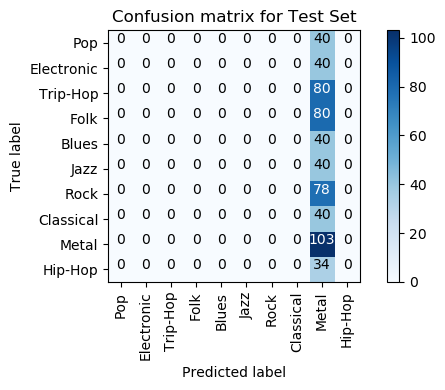

In [29]:
from sklearn.metrics import confusion_matrix


# conf_mat_val = confusion_matrix(y_val_gold, y_val_pred)
# plot_confusion_matrix(conf_mat_val, labels, title='Confusion matrix for Validation Set')

conf_mat_test = confusion_matrix(y_test_gold, y_test_pred)
plot_confusion_matrix(conf_mat_test, labels, title='Confusion matrix for Test Set')

**(β)** Έχονντας ως  είσοδο τα beat-synced spectrograms του συνόλου εκπαίδευσης έχουμε:

In [30]:
train_loader, val_loader = torch_train_val_split(train_specs_beat_mel, BATCH_SIZE ,BATCH_SIZE, val_size=.33, shuffle=True)
test_loader = DataLoader(test_specs_beat_mel, batch_size=BATCH_SIZE, shuffle=True)

INPUT_SIZE = train_specs_beat_mel.feat_dim
OUTPUT_SIZE = len(list(set(train_specs_beat_mel.labels)))

model = BasicLSTM(input_dim=INPUT_SIZE, hidden_dim=20, output_dim=OUTPUT_SIZE, num_layers=2).to(DEVICE)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model, 
                                                        loss_function, optimizer)

 [============================------------] ...Epoch 1, Loss: 2.3248Train Set: loss=2.2861
Validation Set: loss=2.2910, accuracy=0.1500

 [============================------------] ...Epoch 2, Loss: 2.2927Train Set: loss=2.2803
Validation Set: loss=2.2796, accuracy=0.1921

 [============================------------] ...Epoch 3, Loss: 2.2982Train Set: loss=2.2704
Validation Set: loss=2.2769, accuracy=0.1921

 [============================------------] ...Epoch 4, Loss: 2.1984Train Set: loss=2.2646
Validation Set: loss=2.2711, accuracy=0.1921

 [============================------------] ...Epoch 5, Loss: 2.2429Train Set: loss=2.2616
Validation Set: loss=2.2653, accuracy=0.1921

 [============================------------] ...Epoch 6, Loss: 2.2425Train Set: loss=2.2537
Validation Set: loss=2.2599, accuracy=0.1921

 [============================------------] ...Epoch 7, Loss: 2.2984Train Set: loss=2.2497
Validation Set: loss=2.2545, accuracy=0.1921

 [============================-----------

In [31]:
y_test_pred, y_test_gold = test_model(test_loader, model, loss_function, "Test")


Test Set: loss=2.2413, accuracy=0.1791, f1-macro=0.0304


In [32]:
from sklearn.metrics import classification_report

labels = list(set(test_specs_mel.gold_labels))
print(classification_report(y_test_gold, y_test_pred, target_names=labels))

              precision    recall  f1-score   support

         Pop       0.00      0.00      0.00        40
  Electronic       0.00      0.00      0.00        40
    Trip-Hop       0.00      0.00      0.00        80
        Folk       0.00      0.00      0.00        80
       Blues       0.00      0.00      0.00        40
        Jazz       0.00      0.00      0.00        40
        Rock       0.00      0.00      0.00        78
   Classical       0.00      0.00      0.00        40
       Metal       0.18      1.00      0.30       103
     Hip-Hop       0.00      0.00      0.00        34

    accuracy                           0.18       575
   macro avg       0.02      0.10      0.03       575
weighted avg       0.03      0.18      0.05       575



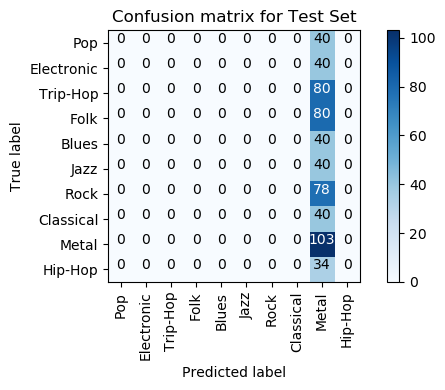

In [33]:
from sklearn.metrics import confusion_matrix


# conf_mat_val = confusion_matrix(y_val_gold, y_val_pred)
# plot_confusion_matrix(conf_mat_val, labels, title='Confusion matrix for Validation Set')

conf_mat_test = confusion_matrix(y_test_gold, y_test_pred)
plot_confusion_matrix(conf_mat_test, labels, title='Confusion matrix for Test Set')

**(γ)** Έχονντας ως  είσοδο τα χρωμογραφήματα του συνόλου εκπαίδευσης έχουμε:

In [34]:
train_loader, val_loader = torch_train_val_split(chromas_train, BATCH_SIZE ,BATCH_SIZE, val_size=.33, shuffle=True)
test_loader = DataLoader(chromas_test, batch_size=BATCH_SIZE, shuffle=True)

INPUT_SIZE = chromas_train.feat_dim
OUTPUT_SIZE = len(list(set(chromas_train.labels)))

model = BasicLSTM(input_dim=INPUT_SIZE, hidden_dim=20, output_dim=OUTPUT_SIZE, num_layers=2).to(DEVICE)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model, 
                                                        loss_function, optimizer)

 [============================------------] ...Epoch 1, Loss: 2.2505Train Set: loss=2.2957
Validation Set: loss=2.3008, accuracy=0.1474

 [============================------------] ...Epoch 2, Loss: 2.3097Train Set: loss=2.2957
Validation Set: loss=2.2958, accuracy=0.1487

 [============================------------] ...Epoch 3, Loss: 2.3507Train Set: loss=2.2895
Validation Set: loss=2.2910, accuracy=0.1513

 [============================------------] ...Epoch 4, Loss: 2.2390Train Set: loss=2.2857
Validation Set: loss=2.2863, accuracy=0.1474

 [============================------------] ...Epoch 5, Loss: 2.3645Train Set: loss=2.2836
Validation Set: loss=2.2821, accuracy=0.1500

 [============================------------] ...Epoch 6, Loss: 2.2402Train Set: loss=2.2801
Validation Set: loss=2.2781, accuracy=0.1513

 [============================------------] ...Epoch 7, Loss: 2.2978Train Set: loss=2.2754
Validation Set: loss=2.2740, accuracy=0.1474

 [============================-----------

In [35]:
y_test_pred, y_test_gold = test_model(test_loader, model, loss_function, "Test")


Test Set: loss=2.2658, accuracy=0.1391, f1-macro=0.0351


In [36]:
from sklearn.metrics import classification_report

labels = list(set(test_specs_mel.gold_labels))
print(classification_report(y_test_gold, y_test_pred, target_names=labels))

              precision    recall  f1-score   support

         Pop       0.00      0.00      0.00        40
  Electronic       0.00      0.00      0.00        40
    Trip-Hop       0.14      0.91      0.24        80
        Folk       0.15      0.09      0.11        80
       Blues       0.00      0.00      0.00        40
        Jazz       0.00      0.00      0.00        40
        Rock       0.00      0.00      0.00        78
   Classical       0.00      0.00      0.00        40
       Metal       0.00      0.00      0.00       103
     Hip-Hop       0.00      0.00      0.00        34

    accuracy                           0.14       575
   macro avg       0.03      0.10      0.04       575
weighted avg       0.04      0.14      0.05       575



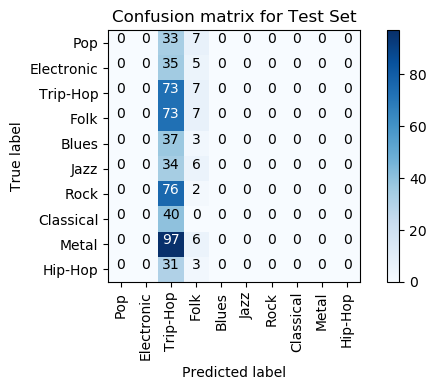

In [37]:
from sklearn.metrics import confusion_matrix


# conf_mat_val = confusion_matrix(y_val_gold, y_val_pred)
# plot_confusion_matrix(conf_mat_val, labels, title='Confusion matrix for Validation Set')

conf_mat_test = confusion_matrix(y_test_gold, y_test_pred)
plot_confusion_matrix(conf_mat_test, labels, title='Confusion matrix for Test Set')

**(δ) (Bonus)** Έχονντας ως  είσοδο τα concatenated features του συνόλου εκπαίδευσης έχουμε:

In [38]:
train_specs_fused = SpectrogramDataset(
     fma_genre_spectr_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_fused_spectrogram)

print("Train Loaded Successfuly.", "Train data length:", len(train_specs_fused))

test_specs_fused = SpectrogramDataset(
     fma_genre_spectr_path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_fused_spectrogram)
    
print("Test Loaded Successfuly.", "Test data length:", len(test_specs_fused))

Train Loaded Successfuly. Train data length: 2305
Test Loaded Successfuly. Test data length: 575


In [39]:
train_loader, val_loader = torch_train_val_split(train_specs_fused, BATCH_SIZE ,BATCH_SIZE, val_size=.33, shuffle=True)
test_loader = DataLoader(test_specs_fused, batch_size=BATCH_SIZE, shuffle=True)

INPUT_SIZE = train_specs_fused.feat_dim
OUTPUT_SIZE = len(list(set(train_specs_fused.labels)))

model = BasicLSTM(input_dim=INPUT_SIZE, hidden_dim=20, output_dim=OUTPUT_SIZE, num_layers=2).to(DEVICE)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model, 
                                                        loss_function, optimizer)

 [============================------------] ...Epoch 1, Loss: 2.2583Train Set: loss=2.3010
Validation Set: loss=2.2977, accuracy=0.0737

 [============================------------] ...Epoch 2, Loss: 2.2510Train Set: loss=2.2900
Validation Set: loss=2.2880, accuracy=0.1158

 [============================------------] ...Epoch 3, Loss: 2.1929Train Set: loss=2.2800
Validation Set: loss=2.2786, accuracy=0.1803

 [============================------------] ...Epoch 4, Loss: 2.3128Train Set: loss=2.2765
Validation Set: loss=2.2735, accuracy=0.1842

 [============================------------] ...Epoch 5, Loss: 2.2249Train Set: loss=2.2709
Validation Set: loss=2.2693, accuracy=0.1842

 [============================------------] ...Epoch 6, Loss: 2.3135Train Set: loss=2.2665
Validation Set: loss=2.2651, accuracy=0.1829

 [============================------------] ...Epoch 7, Loss: 2.3344Train Set: loss=2.2629
Validation Set: loss=2.2614, accuracy=0.1829

 [============================-----------

In [40]:
y_test_pred, y_test_gold = test_model(test_loader, model, loss_function, "Test")


Test Set: loss=2.2526, accuracy=0.1791, f1-macro=0.0304


In [41]:
from sklearn.metrics import classification_report

labels = list(set(test_specs_mel.gold_labels))
print(classification_report(y_test_gold, y_test_pred, target_names=labels))

              precision    recall  f1-score   support

         Pop       0.00      0.00      0.00        40
  Electronic       0.00      0.00      0.00        40
    Trip-Hop       0.00      0.00      0.00        80
        Folk       0.00      0.00      0.00        80
       Blues       0.00      0.00      0.00        40
        Jazz       0.00      0.00      0.00        40
        Rock       0.00      0.00      0.00        78
   Classical       0.00      0.00      0.00        40
       Metal       0.18      1.00      0.30       103
     Hip-Hop       0.00      0.00      0.00        34

    accuracy                           0.18       575
   macro avg       0.02      0.10      0.03       575
weighted avg       0.03      0.18      0.05       575



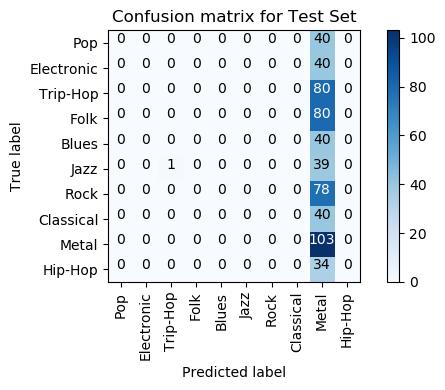

In [42]:
from sklearn.metrics import confusion_matrix


# conf_mat_val = confusion_matrix(y_val_gold, y_val_pred)
# plot_confusion_matrix(conf_mat_val, labels, title='Confusion matrix for Validation Set')

conf_mat_test = confusion_matrix(y_test_gold, y_test_pred)
plot_confusion_matrix(conf_mat_test, labels, title='Confusion matrix for Test Set')

---